In [1]:
# INTEL CORPORATION CONFIDENTIAL AND PROPRIETARY
# 
# Copyright © 2018-2021 Intel Corporation.
# 
# This software and the related documents are Intel copyrighted
# materials, and your use of them is governed by the express 
# license under which they were provided to you (License). Unless
# the License provides otherwise, you may not use, modify, copy, 
# publish, distribute, disclose or transmit  this software or the
# related documents without Intel's prior written permission.
# 
# This software and the related documents are provided as is, with
# no express or implied warranties, other than those that are 
# expressly stated in the License.

# Interactive Spike Sender and Spike Receivers

This tutorial shows how you could use spike generation processes and spike receivers to create a interactive workflow. The spike receivers are used for live monitoring but they could also be used to generate run time spikes as reinforcements.

In [2]:
%matplotlib notebook

import nxsdk.api.n2a as nx
import numpy as np
from time import sleep

import matplotlib
import matplotlib.pyplot as plt

from threading import Thread, Event

# Number of timesteps to run
NUM_TIMESTEPS=3000

# Number of plots for each spike receiver (corresponds to how many compartments are connected with the spike receiver)
NUM_PLOTS_PER_RECEIVER=GROUP_SIZE=3

## Network Architecture

The following is an illustration of the network used in the tutorial:

![Spike Generators and Spike Receivers](figures/jupyter_interactive_spike_generator_with_receiver.png)

## CompartmentGroups and Connections

We create 2 compartment groups of size 3 using the different compartment prototypes. We connect the first compartment group with the second using a connection mask representing one-to-one connection and a connection prototype comprising of weight value of 32. 

The compartmentThreshold is being set to a low value of 64 to make them spike more frequently.

In [3]:
net = nx.NxNet()

compartmentPrototype = nx.CompartmentPrototype(functionalState=nx.COMPARTMENT_FUNCTIONAL_STATE.IDLE)
compartmentPrototype.compartmentThreshold = 64

cg1 = net.createCompartmentGroup(prototype=compartmentPrototype, size=GROUP_SIZE)

Next we create the second compartment group with a higher threshold.

In [4]:
compartmentPrototype.compartmentThreshold = 6400

cg2 = net.createCompartmentGroup(prototype=compartmentPrototype, size=GROUP_SIZE)

connectionPrototype = nx.ConnectionPrototype(weight=32)

# Create one to one connection between the 2 compartment groups
conngrp = cg1.connect(cg2, prototype=connectionPrototype, connectionMask=np.eye(GROUP_SIZE))

## Spike Generation Processes (Basic and Interactive)

We first define a basic spikegen process which will be used to insert spikes at pre-determined timesteps. The basicSpikeGen is connected to the first compartment group and spikes are injected at certain timesteps. Note that these spikes are bufferred and will only be injected after the network starts running. Once all requested timesteps have been finished, the user can then add more spikes using this basic spikegen process and invoke net.run or net.runAsync again.

In [5]:
basicSpikeGen = net.createSpikeGenProcess(numPorts=1)

connectionPrototype.weight = 128

basicSpikeGenConnGrp = basicSpikeGen.connect(cg1, prototype=connectionPrototype)

# Inject spikes at these pre-determined timesteps
basicSpikeGen.addSpikes(0, [1,2,4,8,16,32,64,128,256,512,1024,2048])

Next, we define a interactive spikegen process which will be used to insert spikes at runtime. The interactiveSpikeGen implements sendSpikes to send spike from this session to the compartment which has been mapped via the input port Id. The spikes will be injected immediately - however realtime is not guaranteed as the superhost and the loihi are executing asynchornously without any common notion of timestep. The Lakemont checks every 10ms for spikes from the interactiveSpikeGen and injects them to connected compartments.

In [6]:
interactiveSpikeGen = net.createInteractiveSpikeGenProcess(numPorts=1)

interactiveSpikeGenConnGrp = interactiveSpikeGen.connect(cg1, prototype=connectionPrototype)

*API References*:
[BasicSpikeGen](spikeinjectionandreceivers.html#nxsdk.net.process.basicspikegen.BasicSpikeGen)
[InteractiveSpikeGen](spikeinjectionandreceivers.html#nxsdk.net.process.interactivespikegen.InteractiveSpikeGen)

## Spike Receivers

We define two spike receivers connecting each to the compartment group to monitor the spike activity interactively. Spike Receivers poll the spike activity and notify using the callback methods registered with each receiver. The notification method is passed the spike activity data accrued since the last invocation.

In [7]:
spikeReceiver1 = nx.SpikeReceiver(net)
cg1.connect(spikeReceiver1)

spikeReceiver2 = nx.SpikeReceiver(net)
cg2.connect(spikeReceiver2)

We create a callable class and two callable objects acting like buffers to hold the output of the spike receivers. These callable objects will be registered as callbacks to the two receivers respectively.

In [8]:
class Callable:
    def __init__(self, index):
        # data will hold the spike activity for the 3 compartments associated with a spikereceiver
        # Each spikereceiver will have its own Callable instance as the callback. This is denoted by index
        self.data = [[] for i in range(NUM_PLOTS_PER_RECEIVER)]
        self.index = index

    def __call__(self, *args, **kwargs):
        # At every invocation of this method, new data since the last invocation will be passed along.
        # args[0] essentially is a list[list]. Length of the parent list is the number of compartments 
        # connecting to this spike receiver while each sublist is the timeseries data assciated with that
        # compartment accrued since the last invocation. len(args) is 1.
        for compartmentId, tsData in enumerate(args[0]):
            self.data[compartmentId].extend(tsData)
        
callable1 = Callable(1)
callable2 = Callable(2)

# Register these callable objects as callbacks
spikeReceiver1.callback(callable1)
spikeReceiver2.callback(callable2)

*API Reference*: [SpikeReceiver](spikeinjectionandreceivers.html#nxsdk.net.process.spikereceiver.SpikeReceiver)

## Spike Activity Monitoring (Live)

We use matplotlib to plot the compartment group spike activity. We run the animation, putting the event plots, at a 0.5s refresh rate.

Spikes associated with interactive spike and basic spike injection are interspersed for compartments in compartment group1 (spikereceiver1). SpikesReceiver2 records spikes only when the compartmentgroup2 spikes which happens less often.

In [9]:
class AsyncPlotter:
    """Async Plotter plots the callableObjects in a backend thread by repeatedly polling for new data"""
    def __init__(self, numPlotsPerReceiver, callableObjects, timesteps):
        self.thread = Thread(target=AsyncPlotter.plot, args=(numPlotsPerReceiver, callableObjects, timesteps), daemon=True)
        self.thread.start()
        
    @staticmethod
    def plot(numPlotsPerObject, callableObjects, timesteps):
        try:
            fig = plt.figure(figsize=(8, 6))
            eventColors = ['blue', 'red']
            
            # Axes is a 2D list of axes. Each sublist consists of axes for a plot
            axes = [[] for c in callableObjects]
            figIndexIter = iter(range(1, numPlotsPerObject*len(callableObjects)+1))
            for i in range(numPlotsPerObject):
                for index, obj in enumerate(callableObjects):
                    figIndex = next(figIndexIter)
                    ax = plt.subplot(numPlotsPerObject, len(callableObjects), figIndex)
                    
                    ax.set_xlim((0, NUM_TIMESTEPS))
                    plt.title("SpikeReceiver{} Compartment{}".format(index+1, i+1))
                    axes[index].append(ax)
            
            plt.ion()
            fig.show()
            fig.canvas.draw()
            plt.tight_layout()
            
            # Loop till all timesteps are complete
            while len(callableObjects[0].data[0]) != timesteps:
                sleep(0.5)
                for objIndex, subplot in enumerate(axes):
                    for index, ax in enumerate(subplot):
                        ax.eventplot(np.where(callableObjects[objIndex].data[index]), colors=eventColors[objIndex])
                fig.canvas.draw()                    
                        
        except Exception as e:
            print(str(e))
        print("Plotting Complete")

# Instantiate AsyncPlotter and start the non-blocking plotter before running the network
ap = AsyncPlotter(NUM_PLOTS_PER_RECEIVER, [callable1, callable2], NUM_TIMESTEPS)

## Execution and Interactive Spike Generation

We run the network in non-blocking mode for NUM_TIMESTEPS and then use the interactiveSpikeGen process to send spikes while the job is running.

We will send spikes to the compartment group1 every second. We can use the numSpikes parameter to send more than one spike at a time. 

.. note:: 
    Some spikes may be batched due to network latencies. 

You should also use the correct input port Id as input port Ids are shared between all spike gen processes.

Once all spikes have been sent, we wait for all timesteps to complete and disconnect. You may also use ``net.stop()`` for immediate halt which does not wait for all timesteps to finish.

<IPython.core.display.Javascript object>


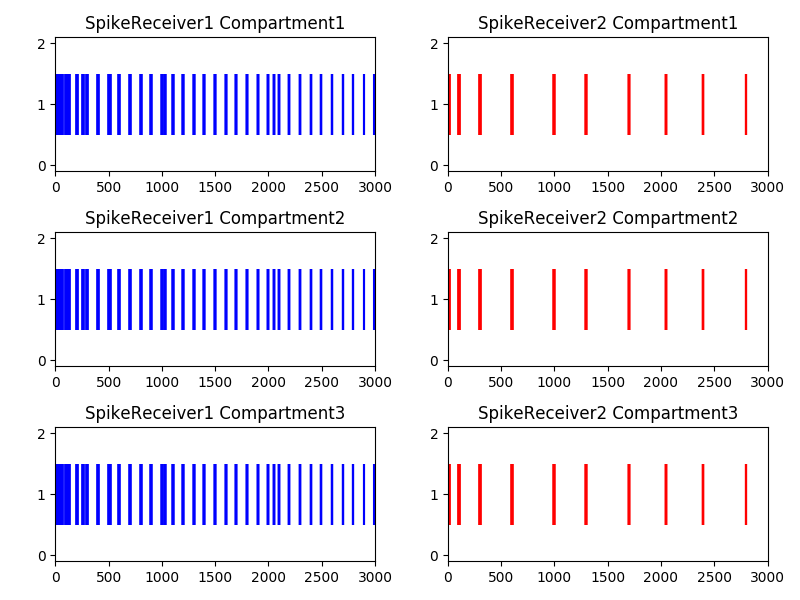

INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 134.134.68.81:33463
INFO:DRV:      Host server up..............Done 0.18s
INFO:DRV:      Compiling snips.............Done 0.34s
INFO:DRV:      Encoding axons/synapses.....Done 2.21ms
INFO:DRV:      Encoding probes.............Done 0.14ms
INFO:DRV:      Booting up..................Done 2.59s
INFO:DRV:      Transferring probes.........Done 2.56ms
INFO:DRV:      Transferring spikes.........Done 1.39ms
INFO:DRV:      Configuring registers.......Done 3.13ms
Plotting Complete
INFO:DRV:      Executing...................Done 1.21ms
INFO:DRV:      Processing timeseries.......Done 1.14ms


In [10]:
# Run Asynchronously (Non-Blocking)
net.runAsync(numSteps=NUM_TIMESTEPS)

# Send Spikes
for i in range(50):
    sleep(1)
    interactiveSpikeGen.sendSpikes(spikeInputPortNodeIds=[1], numSpikes=[3])
    
# net.stop()
net.disconnect()

Stop the Asynchronous Plotter

Users could use probes while experimenting with network creation while spike receivers are helpful once the network is built and external stimulus (like spike injection) are being experimented. Probes can be used along with Spike Receivers - However, probes are evaluated at end of a run.

.. code-links:: python clear